In [3]:
import numpy as np
import pandas as pd
import os
import glob
import itertools
import scanpy as sc
import natsort

from scroutines import basicu

In [4]:
selected_genes = [
    "Igsf9b",
]
len(selected_genes)

1

In [5]:
ddir = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized'
outdir = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/GABAARs'
!mkdir -p $outdir

In [6]:
### read in the file and prep

all_subtensors = {}

for i, f in enumerate(natsort.natsorted(glob.glob(ddir+'/*.h5ad'))):
    print(f)
    cond_name = os.path.basename(f)[:-len('.h5ad')]

    adata = sc.read(f)
    adata.obs['biosample'] = adata.obs['sample'].apply(lambda x: x[:-1])
    if i == 0:
        genes = adata.var.index.values
    else:
        assert np.all(genes == adata.var.index.values)
        
    selected_genes_idx = basicu.get_index_from_array(genes, selected_genes)
    assert np.any(selected_genes_idx != -1)

    ### sum over counts 
    # by sample
    sample_lbls = adata.obs['biosample'].values
    unq_samples = np.unique(sample_lbls)

    # by type
    type_lbls = adata.obs['Subclass'].values
    unq_types = np.unique(type_lbls)

    nr, nc, ng =  len(unq_samples), len(unq_types), len(adata.var)  #  rep, subclass, gene 
    tensor = np.zeros((nr, nc, ng))
    print(tensor.shape)

    for j, this_samp in enumerate(unq_samples):
        for k, this_type in enumerate(unq_types):
            selector = ((sample_lbls==this_samp) & (type_lbls==this_type))
            tensor[j,k] = np.sum(np.array(adata[selector].X.todense()), axis=0) # raw reads sum over all cells

    ### CPM  - per sample and subclass
    # normalize it as log2(1+CPM)
    tensor = (tensor/np.sum(tensor, axis=-1, keepdims=True))*1e6
    tensor = np.log2(1+tensor) 

    ### select GABARRs
    subtensor = tensor[:,:,selected_genes_idx]
    print(subtensor.shape)
    
    all_subtensors[cond_name] = subtensor



/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P8NR.h5ad
(2, 20, 53801)
(2, 20, 1)
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P14NR.h5ad
(2, 20, 53801)
(2, 20, 1)
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P17NR.h5ad
(2, 20, 53801)
(2, 20, 1)
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P21NR.h5ad
(2, 20, 53801)
(2, 20, 1)
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P28DL.h5ad
(2, 20, 53801)
(2, 20, 1)
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P28DR.h5ad
(2, 20, 53801)
(2, 20, 1)
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P28NR.h5ad
(2, 20, 53801)
(2, 20, 1)
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P38DR.h5ad
(2, 20, 53801)
(2, 20, 1)
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/orga

In [11]:
unq_types, unq_types.shape, 

(array(['Astro', 'Endo', 'Frem1', 'L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT',
        'L6CT', 'L6IT', 'L6b', 'Lamp5', 'Micro', 'OD', 'OPC', 'Pvalb',
        'Sst', 'Stac', 'VLMC', 'Vip'], dtype=object),
 (20,),
 array([15]))

In [18]:


all_subtensors['P8NR'][:,15,0]

array([6.46046809, 6.45603662])

In [13]:
cond_name

'P38NR'

In [19]:
all_subtensors.keys()

dict_keys(['P8NR', 'P14NR', 'P17NR', 'P21NR', 'P28DL', 'P28DR', 'P28NR', 'P38DR', 'P38NR'])

# plot


In [27]:
import matplotlib.pyplot as plt
from scroutines.config_plots import *

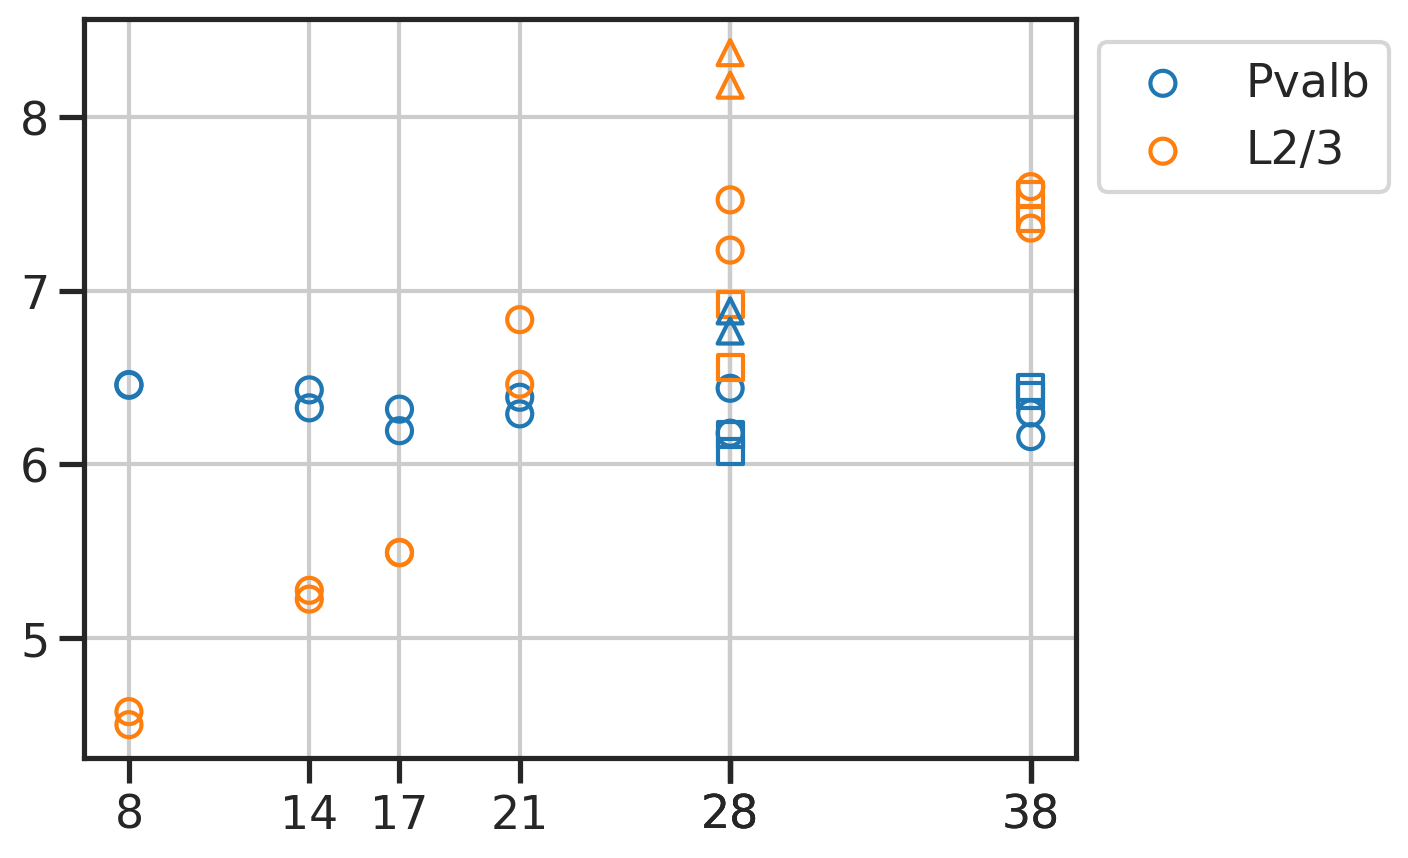

In [49]:
conds = ['P8NR', 'P14NR', 'P17NR', 'P21NR', 'P28NR', 'P38NR', 'P28DR', 'P38DR', 'P28DL']
times = [8, 14, 17, 21, 28, 38,                               28, 38,            28]

types = ['Pvalb', 'L2/3']
type_indices = basicu.get_index_from_array(unq_types, types)

gn_idx = 0


fig, ax = plt.subplots()
ax.set_xticks(times)
for i, (cond, time) in enumerate(zip(conds, times)):
    if   cond.endswith('NR'):
        marker = 'o'
    elif cond.endswith('DR'):
        marker = 's'
    elif cond.endswith('DL'):
        marker = '^'
        
    for j, (type_idx, type_name) in enumerate(zip(type_indices, types)):
        if i == 0:
            label = type_name
        else:
            label = None
        vals = all_subtensors[cond][:,type_idx, gn_idx]
        ax.scatter([time]*len(vals), vals, color=f'C{j}', label=label, marker=marker, facecolor='none')
        
ax.legend(bbox_to_anchor=(1,1))
plt.show()

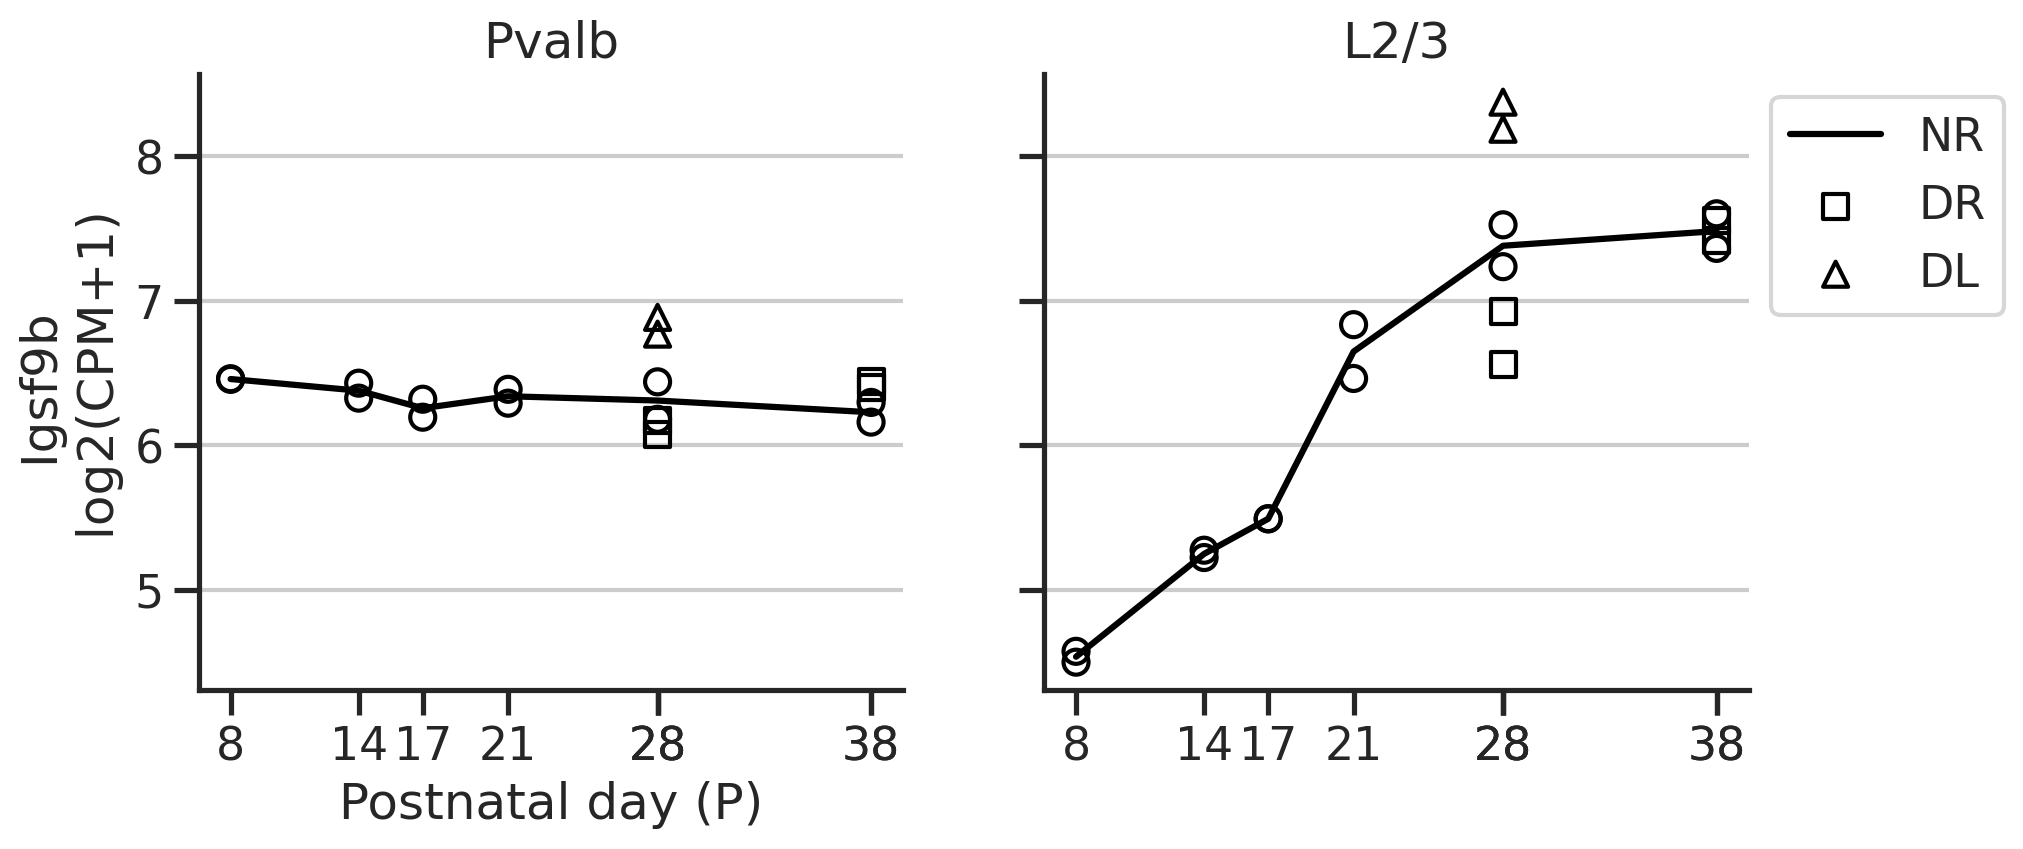

In [86]:
conds = ['P8NR', 'P14NR', 'P17NR', 'P21NR', 'P28NR', 'P38NR', 'P28DR', 'P38DR', 'P28DL']
times = [8, 14, 17, 21, 28, 38,                               28, 38,            28]
nr_times = [8, 14, 17, 21, 28, 38] 

types = ['Pvalb', 'L2/3']
type_indices = basicu.get_index_from_array(unq_types, types)

gn_idx = 0


fig, axs = plt.subplots(1,2,figsize=(2*5,1*4), sharex=True, sharey=True)
for j, (type_idx, type_name) in enumerate(zip(type_indices, types)):
    ax = axs[j]
    ax.set_xticks(times)
    ax.set_title(type_name)
    val_mean = []
    for i, (cond, time) in enumerate(zip(conds, times)):
        vals = all_subtensors[cond][:,type_idx, gn_idx]
        if cond.endswith('NR'):
            marker = 'o'
            label = 'NR'
            val_mean.append(np.mean(vals))
        elif cond.endswith('DR'):
            marker = 's'
            label = 'DR'
        elif cond.endswith('DL'):
            marker = '^'
            label = 'DL'
        ax.scatter([time]*len(vals), vals, color='k', marker=marker, facecolor='none', label=label)
        
    ax.plot(nr_times, val_mean, '-k', label='NR')
    sns.despine(ax=ax)
    ax.grid(axis='x')
        
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), bbox_to_anchor=(1,1))

axs[0].set_ylabel('Igsf9b \n log2(CPM+1)')
axs[0].set_xlabel('Postnatal day (P)')
plt.show()

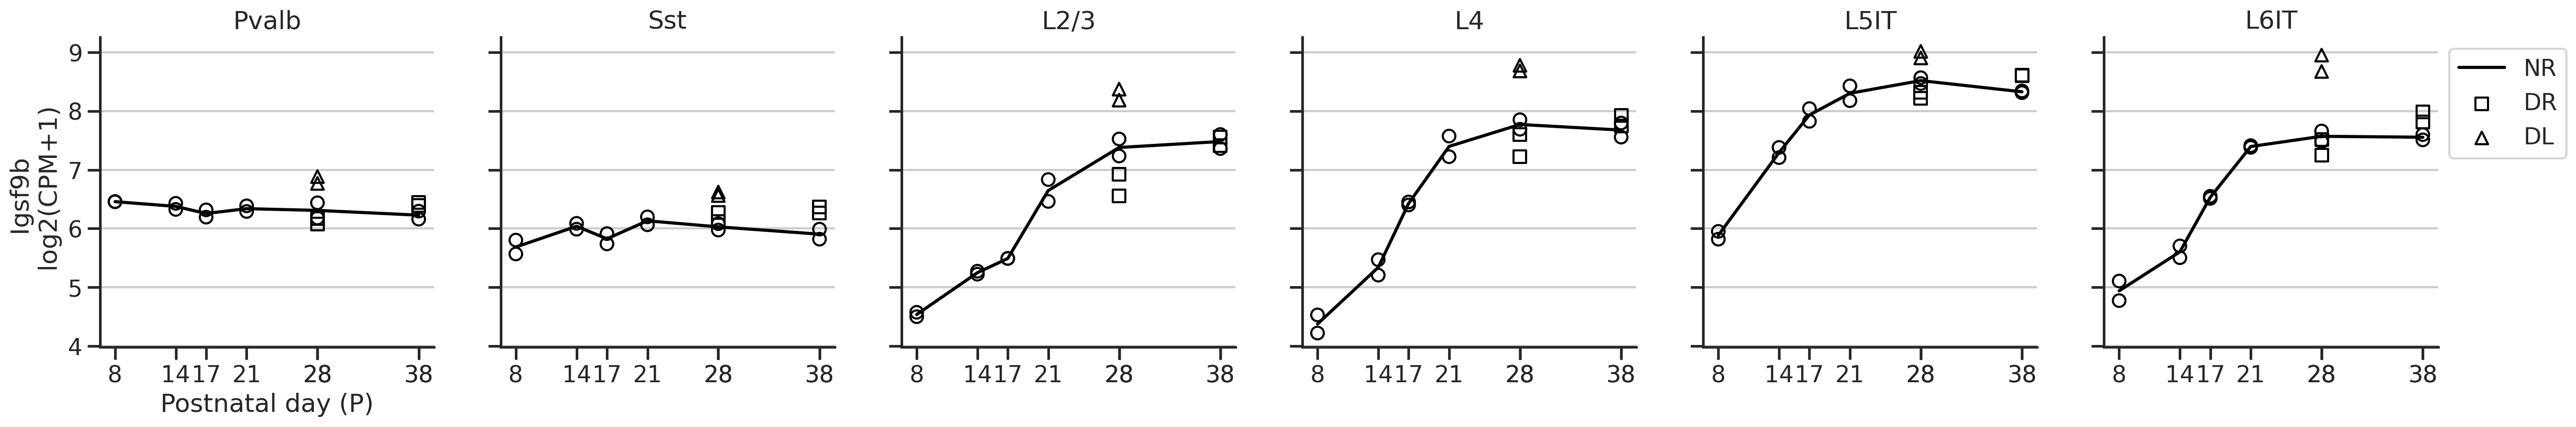

In [96]:
conds = ['P8NR', 'P14NR', 'P17NR', 'P21NR', 'P28NR', 'P38NR', 'P28DR', 'P38DR', 'P28DL']
times = [8, 14, 17, 21, 28, 38,                               28, 38,            28]
nr_times = [8, 14, 17, 21, 28, 38] 

types = ['Pvalb', 'Sst', 'L2/3', 'L4', 'L5IT', 'L6IT',]# 'L5PT', 'L6CT']#, 'Micro', 'Astro']
n = len(types)
type_indices = basicu.get_index_from_array(unq_types, types)

gn_idx = 0


fig, axs = plt.subplots(1,n,figsize=(n*5,1*4), sharex=True, sharey=True)
for j, (type_idx, type_name) in enumerate(zip(type_indices, types)):
    ax = axs[j]
    ax.set_xticks(times)
    ax.set_title(type_name)
    val_mean = []
    for i, (cond, time) in enumerate(zip(conds, times)):
        vals = all_subtensors[cond][:,type_idx, gn_idx]
        if cond.endswith('NR'):
            marker = 'o'
            label = 'NR'
            val_mean.append(np.mean(vals))
        elif cond.endswith('DR'):
            marker = 's'
            label = 'DR'
        elif cond.endswith('DL'):
            marker = '^'
            label = 'DL'
        ax.scatter([time]*len(vals), vals, color='k', marker=marker, facecolor='none', label=label)
        
    ax.plot(nr_times, val_mean, '-k', label='NR')
    sns.despine(ax=ax)
    ax.grid(axis='x')
        
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), bbox_to_anchor=(1,1))

axs[0].set_ylabel('Igsf9b \n log2(CPM+1)')
axs[0].set_xlabel('Postnatal day (P)')
plt.show()